In [219]:
from typing import List, Optional, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp, shapiro, ttest_ind, mannwhitneyu, chi2_contingency, ttest_rel
from statsmodels.stats.weightstats import zconfint

from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit,StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import catboost as catb
%matplotlib inline

# убираем лишние замечания интерпретатора
import warnings
warnings.simplefilter('ignore')

# import additional packages for WOE/IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
# глобальные переменные WOE/IV
max_bin = 20
force_bin = 3

In [ ]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")

In [157]:
X_train = train.copy()
X_train = X_train.set_index('TransactionID')
X_test = test.copy()
X_test = X_test.set_index('TransactionID')

print("X_train.shape = {} rows, {} cols".format(*train.shape))
print("X_test.shape = {} rows, {} cols".format(*test.shape))

X_train.shape = 50001 rows, 394 cols
X_test.shape = 75000 rows, 394 cols


In [158]:
y_train, y_valid = train_test_split(
    X_train["isFraud"], train_size=0.7, shuffle=True, random_state=1)
X_train, X_valid = train_test_split(
    X_train.drop(["isFraud"], axis=1), train_size=0.7, shuffle=True, random_state=1)

y_test = X_test["isFraud"]
#y_test.sample(frac=1, random_state=1) 
X_test = X_test.drop(["isFraud"], axis=1)
#X_test.sample(frac=1, random_state=1)

cat_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
                'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
train[cat_features].head()

print(X_train['P_emaildomain'].unique(), X_train['R_emaildomain'].unique(), X_train['M1'].unique(),
      X_train['M2'].unique(), X_train['M3'].unique(), X_train['M4'].unique(),
      X_train['M5'].unique(), X_train['M6'].unique(), X_train['M7'].unique(),
      X_train['M8'].unique(), X_train['M9'].unique())

In [159]:
X_train['M1'] = X_train['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_train['M2'] = X_train['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M3'] = X_train['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M4'] = X_train['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_train['M5'] = X_train['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M6'] = X_train['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M7'] = X_train['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M8'] = X_train['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M9'] = X_train['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['ProductCD'] = X_train['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_train['card6'] = X_train['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_train['card4'] = X_train['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_valid['M1'] = X_valid['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_valid['M2'] = X_valid['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M3'] = X_valid['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M4'] = X_valid['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_valid['M5'] = X_valid['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M6'] = X_valid['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M7'] = X_valid['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M8'] = X_valid['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M9'] = X_valid['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['ProductCD'] = X_valid['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_valid['card6'] = X_valid['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_valid['card4'] = X_valid['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_test['M1'] = X_test['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_test['M2'] = X_test['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M3'] = X_test['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M4'] = X_test['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_test['M5'] = X_test['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M6'] = X_test['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M7'] = X_test['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M8'] = X_test['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M9'] = X_test['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['ProductCD'] = X_test['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_test['card6'] = X_test['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_test['card4'] = X_test['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_train['P_emaildomain'] = X_train['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_valid['P_emaildomain'] = X_valid['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['P_emaildomain'] = X_test['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_train['R_emaildomain'] = X_train['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_valid['R_emaildomain'] = X_valid['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['R_emaildomain'] = X_test['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

cat_features = X_train.select_dtypes(include=["object"])
cat_features.head()

In [160]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

train_score = roc_auc_score(y_train, model.predict(X_train))
valid_score = roc_auc_score(y_valid, model.predict(X_valid))
test_score = roc_auc_score(y_test, model.predict(X_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.874, Valid-score: 0.722, Test-score: 0.645


модель сильно недообучена

Вывод: независимо от разбиений, между метриками трейна и теста - пропасть,
    как и предполагалось при EDA
    если не делать перемешивание, то и на валидационной части (НО часть от трейна)
    мы видим такие же уровни как и на тесте.
    Если есть перемешивание, то валидационная часть сильно подрастает, что явно показывает
    зависимости, т.е если бы могли взять часть данных из тестового сета было бы ещё лучше.
    Перемешивание теста результатов не дало по понятным причинам.

Разбиваем трейн на 3 части:

In [177]:
X_train = train.copy()
X_train = X_train.set_index('TransactionID')
X_test = test.copy()
X_test = X_test.set_index('TransactionID')

In [178]:
y_train, y_valid = train_test_split(
    X_train["isFraud"], train_size=0.7, shuffle=True, random_state=1)
X_train, X_valid = train_test_split(
    X_train.drop(["isFraud"], axis=1), train_size=0.7, shuffle=True, random_state=1)

y_test = X_test["isFraud"]
#y_test.sample(frac=1, random_state=1) 
X_test = X_test.drop(["isFraud"], axis=1)
#X_test.sample(frac=1, random_state=1)

X_valid, X_test_ = train_test_split(
    X_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test_ = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

In [179]:
X_train['M1'] = X_train['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_train['M2'] = X_train['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M3'] = X_train['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M4'] = X_train['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_train['M5'] = X_train['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M6'] = X_train['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M7'] = X_train['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M8'] = X_train['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M9'] = X_train['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['ProductCD'] = X_train['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_train['card6'] = X_train['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_train['card4'] = X_train['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_valid['M1'] = X_valid['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_valid['M2'] = X_valid['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M3'] = X_valid['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M4'] = X_valid['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_valid['M5'] = X_valid['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M6'] = X_valid['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M7'] = X_valid['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M8'] = X_valid['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['M9'] = X_valid['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_valid['ProductCD'] = X_valid['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_valid['card6'] = X_valid['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_valid['card4'] = X_valid['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_test['M1'] = X_test['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_test['M2'] = X_test['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M3'] = X_test['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M4'] = X_test['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_test['M5'] = X_test['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M6'] = X_test['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M7'] = X_test['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M8'] = X_test['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M9'] = X_test['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['ProductCD'] = X_test['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_test['card6'] = X_test['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_test['card4'] = X_test['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_test_['M1'] = X_test_['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_test_['M2'] = X_test_['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M3'] = X_test_['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M4'] = X_test_['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_test_['M5'] = X_test_['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M6'] = X_test_['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M7'] = X_test_['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M8'] = X_test_['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['M9'] = X_test_['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test_['ProductCD'] = X_test_['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_test_['card6'] = X_test_['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_test_['card4'] = X_test_['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_train['P_emaildomain'] = X_train['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_valid['P_emaildomain'] = X_valid['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['P_emaildomain'] = X_test['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test_['P_emaildomain'] = X_test_['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_train['R_emaildomain'] = X_train['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_valid['R_emaildomain'] = X_valid['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['R_emaildomain'] = X_test['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)


X_test_['R_emaildomain'] = X_test_['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

In [180]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

train_score = roc_auc_score(y_train, model.predict(X_train))
valid_score = roc_auc_score(y_valid, model.predict(X_valid))
test_score_ = roc_auc_score(y_test_, model.predict(X_test_))
test_score = roc_auc_score(y_test, model.predict(X_test))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score_: {round(test_score_, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.874, Valid-score: 0.732, Test-score_: 0.7, Test-score: 0.645


Т.о., почти ничего не изменилось с Train-score: 0.874, Valid-score: 0.722, Test-score: 0.645
    до: Train-score: 0.874, Valid-score: 0.732, Test-score_: 0.7, Test-score: 0.645

Добавляем бустрап

In [183]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [188]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test_, model.predict(X_test_), roc_auc_score)

calculate_confidence_interval(scores)

(0.6607840841609677, 0.7457425129057255)

У на на тесте roc_auc_score=0.645 - т.о. валидация нехорошая

Text(0.5, 0, 'sampel number')

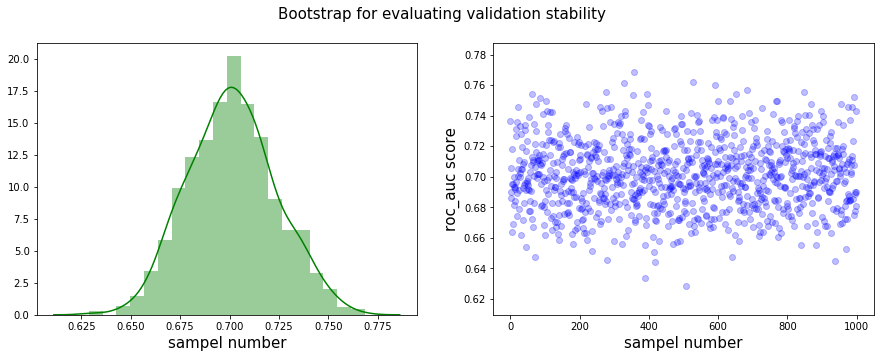

In [190]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("roc_auc score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

видно, что 0.645 лежит за пределами основных элементов множества оценок roc_auc

In [222]:
X_train = train.copy()
y_train = X_train["isFraud"]
X_train = X_train.drop(['isFraud','TransactionID'], axis=1)
X_test = test.copy()
X_test = X_test.drop(['isFraud', 'TransactionID'], axis=1)

In [223]:
X_train['M1'] = X_train['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_train['M2'] = X_train['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M3'] = X_train['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M4'] = X_train['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_train['M5'] = X_train['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M6'] = X_train['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M7'] = X_train['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M8'] = X_train['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['M9'] = X_train['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_train['ProductCD'] = X_train['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_train['card6'] = X_train['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_train['card4'] = X_train['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_test['M1'] = X_test['M1'].map({'nan':'0', 'T':'1'}).astype(float)
X_test['M2'] = X_test['M2'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M3'] = X_test['M3'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M4'] = X_test['M4'].map({'nan':'0', 'M0':'1', 'M1':'2', 'M2':'3'}).astype(float)
X_test['M5'] = X_test['M5'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M6'] = X_test['M6'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M7'] = X_test['M7'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M8'] = X_test['M8'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['M9'] = X_test['M9'].map({'nan':'0', 'T':'1', 'F':'2'}).astype(float)
X_test['ProductCD'] = X_test['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(float)
X_test['card6'] = X_test['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)
X_test['card4'] = X_test['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

X_train['P_emaildomain'] = X_train['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['P_emaildomain'] = X_test['P_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_train['R_emaildomain'] = X_train['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

X_test['R_emaildomain'] = X_test['R_emaildomain'].map({'nan':'0', 'gmail.com':'1',
                        'aol.com':'2', 'optonline.net':'3', 'anonymous.com':'4',
                        'yahoo.com':'5', 'ymail.com':'6', 'bellsouth.net':'7', 'live.com':'8',
                        'hotmail.com':'9', 'sbcglobal.net':'10', 'outlook.com':'11', 'msn.com':'12',
                        'icloud.com':'13', 'live.com.mx':'14', 'comcast.net':'15', 'verizon.net':'16',
                        'me.com':'17', 'aim.com':'18', 'frontier.com':'19', 'mac.com':'20',
                        'cox.net':'21', 'charter.net':'22', 'embarqmail.com':'23', 'yahoo.com.mx':'24',
                        'att.net':'25', 'windstream.net':'26', 'rocketmail.com':'27','frontiernet.net':'28',
                        'roadrunner.com':'29', 'gmx.de':'30', 'netzero.net':'31', 'web.de':'32',
                        'twc.com':'33', 'yahoo.fr':'34', 'gmail':'35', 'earthlink.net':'36',
                        'ptd.net':'37', 'hotmail.fr':'38', 'netzero.com':'39', 'mail.com':'40',
                        'q.com':'41', 'prodigy.net.mx':'42', 'juno.com':'43', 'centurylink.net':'44',
                        'yahoo.co.uk':'45', 'suddenlink.net':'46', 'cableone.net':'47', 'hotmail.es':'48',
                        'hotmail.co.uk':'49', 'outlook.es':'50', 'servicios-ta.com':'51', 'sc.rr.com':'52',
                        'yahoo.de':'53', 'protonmail.com':'54', 'hotmail.de':'55', 'live.fr':'56',
                        'yahoo.es':'57', 'yahoo.co.jp':'58'}).astype(float)

In [216]:
model = lgb.LGBMClassifier(random_state=42)

cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring="roc_auc",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.8883 +/- 0.018


In [224]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [226]:
model = lgb.LGBMClassifier(random_state=42)
cv_strategy = StratifiedKFold(n_splits=10, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X_train, y_train, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 45000, valid-observations = 5001
train-score = 0.8669, valid-score = 0.5699
Fold: 2, train-observations = 45001, valid-observations = 5000
train-score = 0.8629, valid-score = 0.7021
Fold: 3, train-observations = 45001, valid-observations = 5000
train-score = 0.8547, valid-score = 0.614
Fold: 4, train-observations = 45001, valid-observations = 5000
train-score = 0.8637, valid-score = 0.7363
Fold: 5, train-observations = 45001, valid-observations = 5000
train-score = 0.8566, valid-score = 0.6814
Fold: 6, train-observations = 45001, valid-observations = 5000
train-score = 0.8533, valid-score = 0.6833
Fold: 7, train-observations = 45001, valid-observations = 5000
train-score = 0.862, valid-score = 0.6851
Fold: 8, train-observations = 45001, valid-observations = 5000
train-score = 0.8574, valid-score = 0.7528
Fold: 9, train-observations = 45001, valid-observations = 5000
train-score = 0.8611, valid-score = 0.6987
Fold: 10, train-observations = 45001, valid-obse

CV-results valid и OOF-score лежат на границе доверительного интервала: (0.6607840841609677, 0.7457425129057255)